In [107]:
#!/usr/bin/env python
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
import pandas as pd
import pyDOE
from scipy.stats import pearsonr,spearmanr,mannwhitneyu
from scipy.interpolate import interp1d

import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1))

rez=600

In [133]:
#integrate the model and calculate a few extra variables of interest
def run_model(tt,ppt,exp_times,Y1,Y2,k1,k2,h,IC50):

    aS,dS,Bt0,tau,lam,dA,thL,xi,k,aE,dE,E50,w,p,g=goodP_list[ppt] #choose a random model

    X0=np.array([aS/dS,0,0,0,0,aE/dE,0])

    #whole Ab model
    Y_t = Y1*np.exp(-k1*tt%56)+Y2*np.exp(-k2*tt%56)
    I_t = 1/(1+(Y_t/IC50)**-h)

    #HIV dynamics model
    dY = np.zeros(7);
    def model(X,t,Y1,Y2,k1,k2,h,IC50):

        S=X[0]; AU=X[1]; AP=X[2]; LU=X[3]; LP=X[4]; E=X[5]; V=X[6];    

        #add infected cell for each exposure
        exp_in=0
        if t>exp_times[exp_in]:
            AP+=1e-3
            exp_in+=1

        tY=t%56 #keep track of dosing

        Bt=Bt0*(1-1/(1+((Y1*np.exp(-k1*tY)+Y2*np.exp(-k2*tY))/IC50)**-h)) #compute Ab effect on infectivity

        dY[0] = aS - dS*S - Bt*S*V                         #susceptible cells
        dY[1] = (1-tau)*(1-lam)*Bt*S*V - dA*AU - k*E*AU + xi*LU    #active unproductively infected
        dY[2] = tau*(1-lam)*Bt*S*V - dA*AP - k*E*AP + xi*LP        #active productively infected
        dY[3] = (1-tau)*lam*Bt*S*V + thL*LU                #latent unproductively infected
        dY[4] = tau*lam*Bt*S*V + thL*LP                    #latent productively infected
        dY[5] = w*E*(AP+AU)/(E+E50) + aE - dE*E;           #adaptive immune system
        dY[6] = p*AP - g*V - Bt*S*V                        #virus
        return dY

    
    infpoz,maxpoz,t_fp,t_max=0,0,0,0
    
    sol=spi.odeint(model, X0, tt, (Y1,Y2,k1,k2,h,IC50),mxstep=10000)    

    vll=np.log10(sol[:,6]*1e3+1e-10) #viral load as usual in 1mL
    
    if (vll>-10).all() & (vll>2).any():        
        infpoz=np.where(vll>2)[0][0] #index of first positive
        maxpoz=np.where(vll==max(vll))[0][0]
        t_fp=tt[infpoz]
        t_max=tt[maxpoz]
    
    return sol,vll,infpoz,t_fp,t_max


In [134]:
#import the best Robb fit params from before
gf=pd.read_csv('goodP_list.csv')
goodP_list=gf.iloc[:,1:].values.tolist()

pnames=[r'$\alpha_S$',r'$\delta_S$',r'$\beta_0$',r'$\tau$',r'$\lambda$',
        r'$\delta_I$',r'$\theta_L$',r'$\xi$',r'$\kappa$',r'$\alpha_E$',
        r'$\delta_E$',r'$E_{50}$',r'$\omega$',r'$\pi$',r'$\gamma$']

#variables to check sensitivity
variables = ['first contact time ' + r'$t_c$',
             'bnAb conc 1 ' + r'$\mathcal{Y}_1$', 
             'bnAb conc 2 ' + r'$\mathcal{Y}_2$',
             'decay rate 1 ' + r'$k_1$',
             'decay rate 2 ' + r'$k_2$',
             'Hill coefficient ' + r'$h$',
             '50% effectiveness ' + r'$IC_{50}$']

#variable rangez for each cohort
rangez10=np.array([[0, 56], [460.18157580773487, 1523.660410055955], [21.257346915715821, 303.33958994404503], [0.42098209564375422, 34.029494753684688], [0.026143650755233082, 0.075659210797802939], [0.48351545422319281, 1.8162354175187263], [0.031, 12.300000000000001]])
rangez30=np.array([[0, 56], [1417.0687536924652, 2483.4504368552621], [57.860088706565897, 436.93124630753533], [0.90406007929783117, 16.768852709514881], [0.02015311688945523, 0.08171220506458414], [0.48351545422319281, 1.8162354175187263], [0.031, 12.300000000000001]])
rangezC=np.array([[0, 56], [0,0], [0,0], [0.90406007929783117, 16.768852709514881], [0.02015311688945523, 0.08171220506458414], [0.48351545422319281, 1.8162354175187263], [0.031, 12.300000000000001]])


In [135]:
#run each simulation num times

trial_days = 80*7

t_trial=np.linspace(0,trial_days,1e4) #80 week trial

trial_names=['msm10','msm30','msmC','w10','w30','wc']
exposure_rate = [3.,3.,3.,5.,5.,5.] #percent exposures per year
size=[800,800,800,500,500,500]
clist=['tan','cadetblue','k','tan','cadetblue','k']



In [136]:
#set up this simulation

trial=2 #choose which trial
rangez=rangezC #for now set this


In [1]:
0.03/365*560

0.046027397260273974

In [137]:
#actually simulate the trials

trial_vll_data=[]; #keep all viral loads
exp_times_list=[]; #list for exposure times

#lists for variables for correlates of prevention later
var_vals=np.zeros(len(variables)); 
var_vals_list=np.zeros([len(variables),size[trial]])

#simulate exposures
ppt_exposures = np.random.poisson(exposure_rate[trial]/100/365*trial_days,size[trial]) #number of exposures for all participants, many should be 0, but need to compare later

ppt_exposures = ppt_exposures[ppt_exposures>0]

print(ppt_exposures)

lhs_samples = pyDOE.lhs( int(len(variables)), samples=len(ppt_exposures), criterion='center') #create the samples from the number of exposures

for ppt in range(len(ppt_exposures)):

    #make the variable values using the LHS sampling
    var_vals = rangez[:,0]+lhs_samples[ppt,:]*(rangez[:,1]-rangez[:,0])

    var_vals_list[:,ppt]=var_vals #append to all the variables

    #ppt=np.random.randint(0,len(goodP_list)) #choose a random participant ID
        
    tc,Y1,Y2,k1,k2,h,IC50=var_vals #choose LHS range of params, ignore tc for now

    exp_times=[] #list for exposure times
    if ppt_exposures[ppt]>0:
        for k in range(ppt_exposures[ppt]):
            exp_times.append(np.random.randint(0,trial_days))
    
    exp_times.append(trial_days) #need to append so that it's always a list with more than 1 item even for 1 exposure

    exp_times_list.append(exp_times)
    
    sol,vll,infpoz,time_first_pos,t_max=run_model(t_trial,ppt,exp_times,Y1,Y2,k1,k2,h,IC50)
    
    trial_vll_data.append(vll)
    
    #calculate outcomes
    #dt=tY[1]
    #time_to_peak=t_max-tV[0]; #time_to_peak=time_to_peak[time_to_peak>0] #days make sure this only counts good ones
    
    #max_VL=np.min([10,np.nanmax(vll)]) #copies/mL, ignore weird artificially high ones
    #AUC_VL=np.nansum(vll*dt) #copies/mL
    #AUC_E=sol[-1,5] #cells/uL, final number, sort of total recruited
    #Ltot=(sol[-1,3]+sol[-1,4])/sol[-1,0]*1e6 #IUPM at end of 8 weeks
    
    #outcome_list.append([time_first_pos, time_to_peak, max_VL, AUC_VL, AUC_E, Ltot])
    
   

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1
 1 1 1 1 1]


/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in power
/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in double_scalars
/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in log10
/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in greater


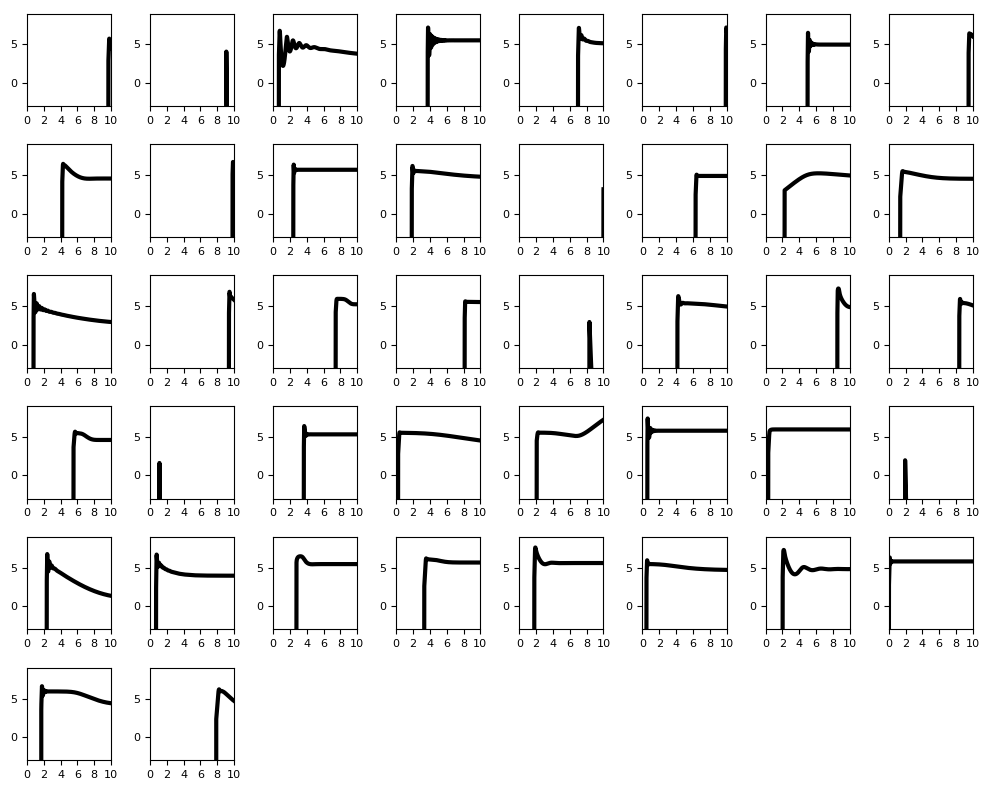

In [138]:
plt.figure(figsize=(10,8),dpi=100)
for j in range(len(ppt_exposures)):
    plt.subplot(6,8,j+1)
    plt.plot(t_trial/56,trial_vll_data[j],color=clist[trial],lw=3) #plot log10(V)
    #plt.title('IC$_{80}=$'+str(round(IC80_counter[j],1))+'\n Ab='+str(round(Ab0_counter[j],1)),fontsize=8)
    plt.tick_params(axis='both', which='major', labelsize=8)
    plt.xlim([0,trial_days/56])
    plt.xticks(range(0,11,2))
    plt.ylim([-3,9])

plt.tight_layout()
plt.savefig(trial_names[trial]+'.pdf')  # No warning now

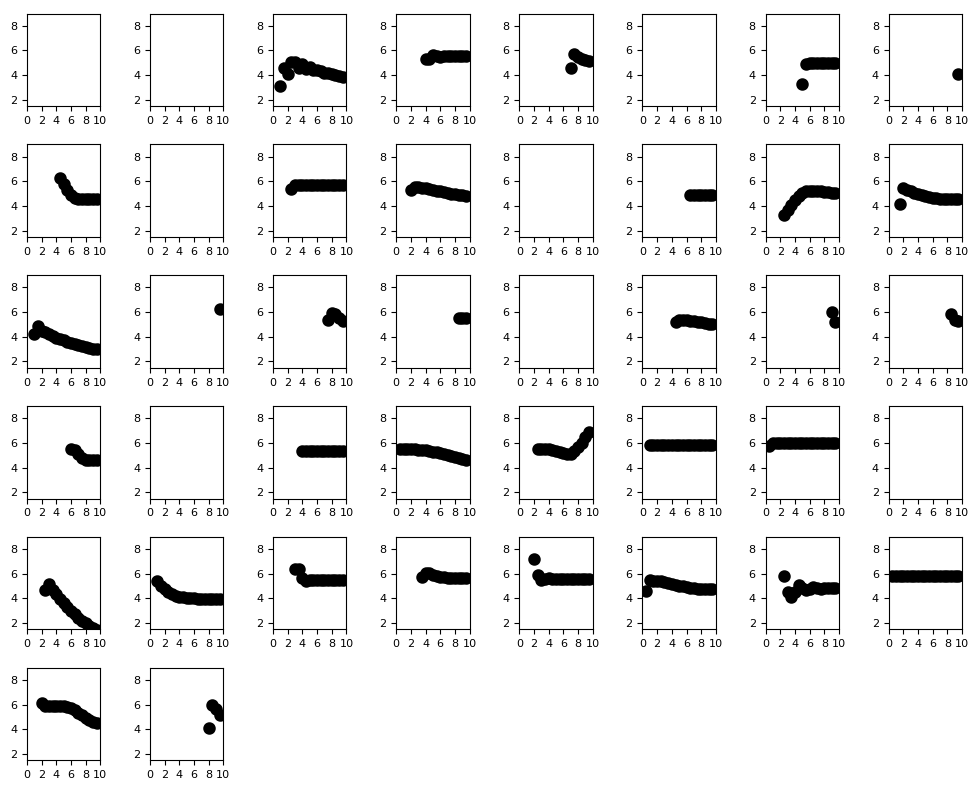

In [139]:
#downsample the data

t_obs = t_trial[0::125*4]/56

plt.figure(figsize=(10,8),dpi=100)
for j in range(len(ppt_exposures)):
    plt.subplot(6,8,j+1)
    plt.scatter(t_obs,trial_vll_data[j][0::125*4],color=clist[trial],lw=3) #plot log10(V)
    plt.tick_params(axis='both', which='major', labelsize=8)
    plt.xlim([0,trial_days/56])
    plt.xticks(range(0,11,2))
    plt.ylim([np.log10(30),9])

plt.tight_layout()
plt.savefig(trial_names[trial]+'_downsample.pdf')  # No warning now

Let's define "breakthrough" virus as any virus above 30 copies/mL, then can look at both observed and true, see if they tell us the same thing.

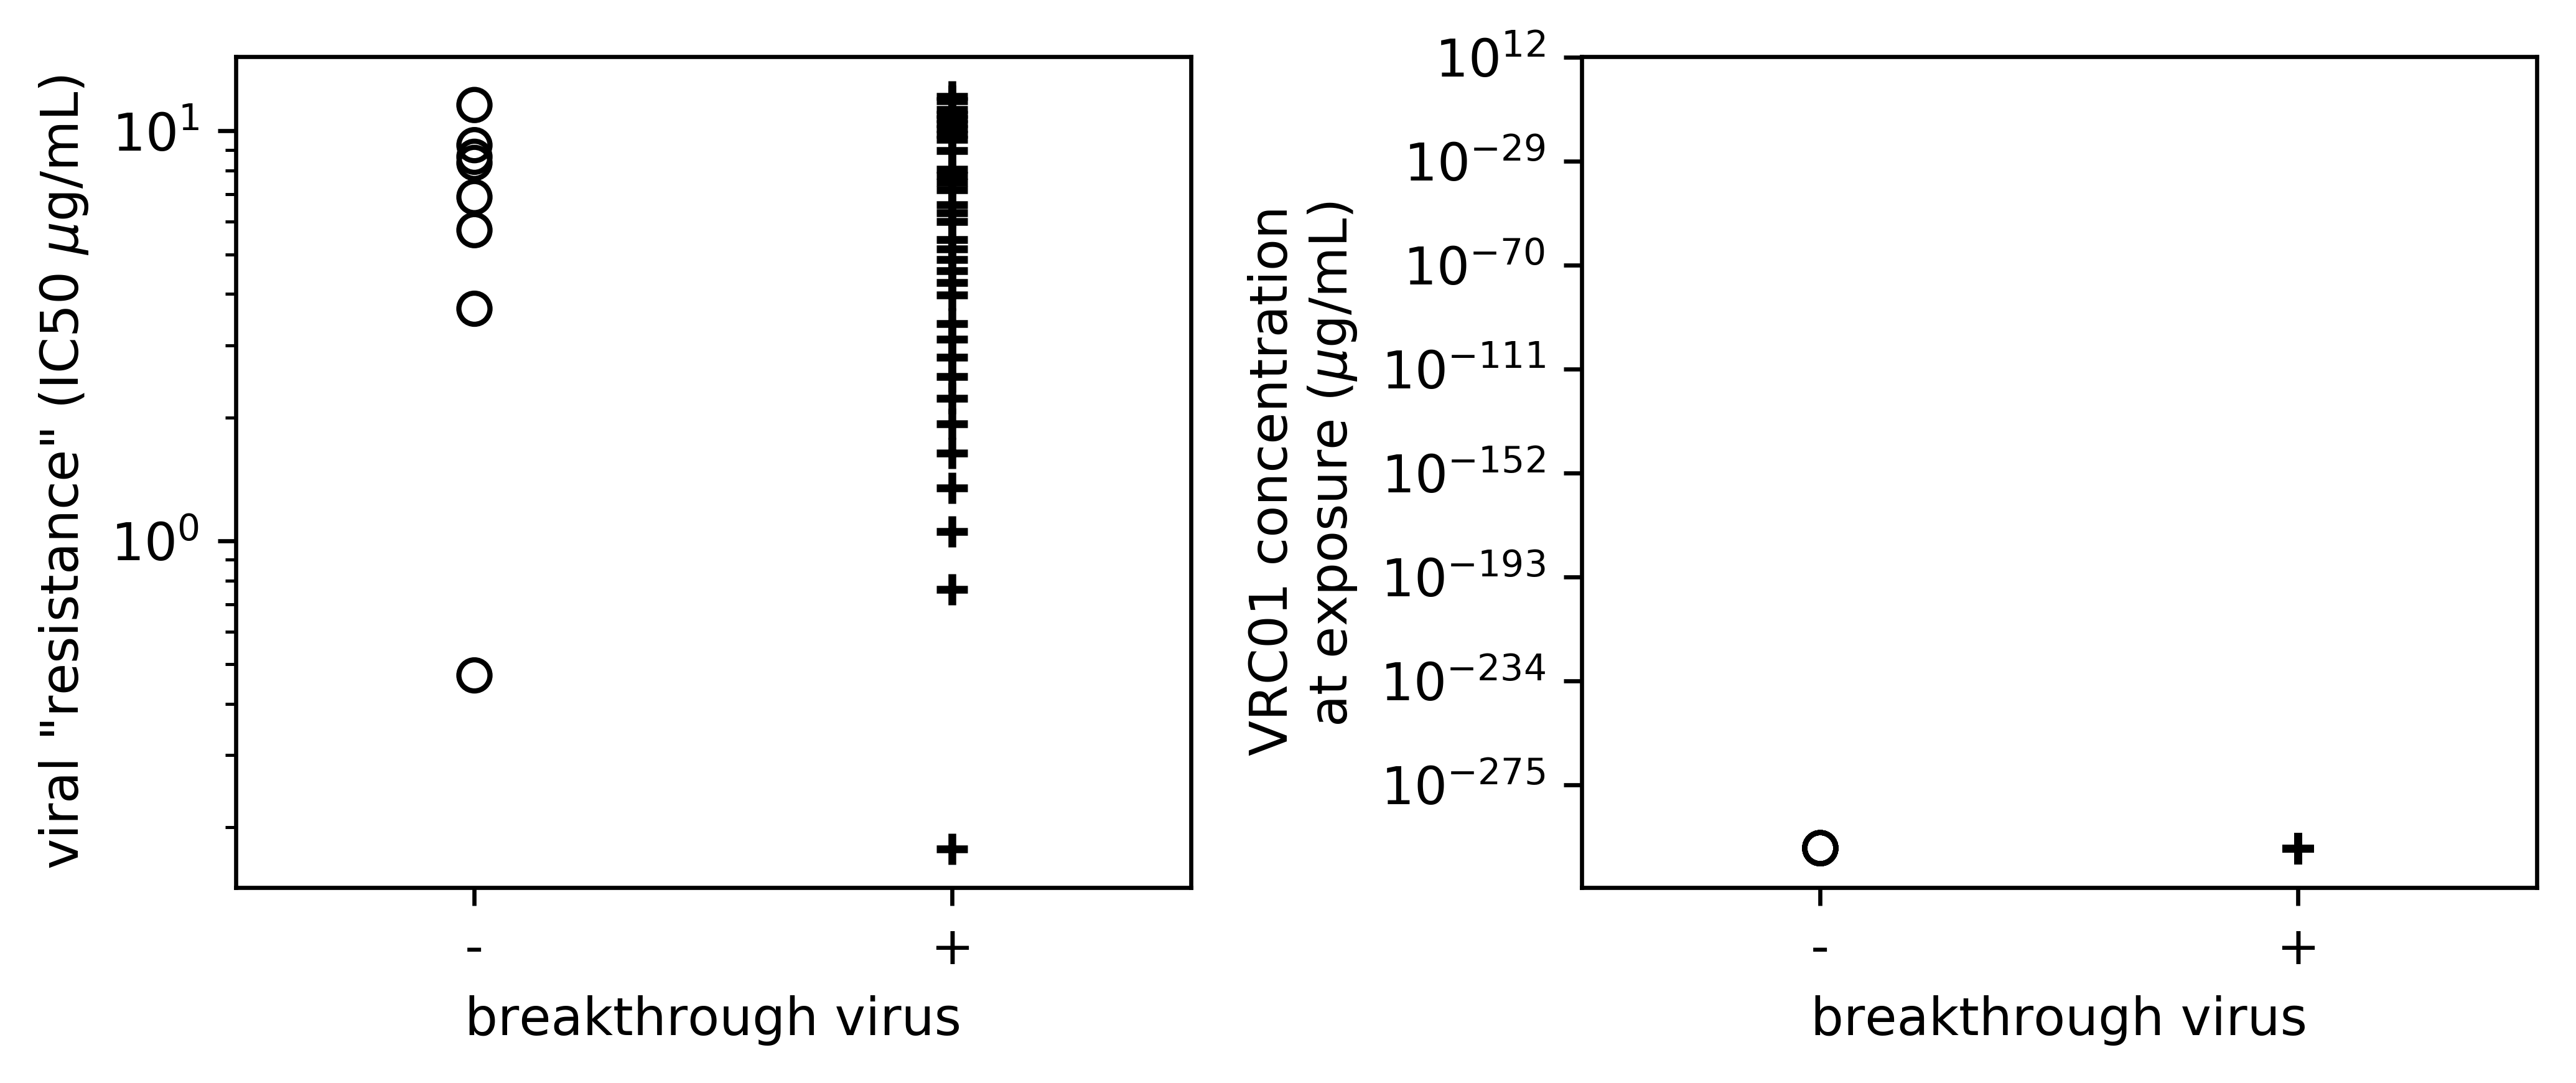

In [140]:
#compare breakthrough virus with Ab parameters
cz=['none',clist[trial]]
mz=['o','+']

BT_list_IC50=[[],[]]
BT_list_Yt=[[],[]]

plt.figure(figsize=(7,3),dpi=rez)
for j in range(len(ppt_exposures)):
    tc,Y1,Y2,k1,k2,h,IC50=var_vals_list[:,j]

    tY=exp_times_list[j][0]%56
    Y_t = Y1*np.exp(-k1*tY)+Y2*np.exp(-k2*tY) #Ab concentration at exposure

    #breakthrough viral load
    ds=trial_vll_data[j][0::125*4]
    
    
    BT=0
    if (ds>np.log10(30)).any():
    #if (trial_vll_data>np.log10(30)).any():
        BT=1
        #VL=np.nanmax(trial_vll_data[j])
    
    BT_list_IC50[BT].append(IC50)
    BT_list_Yt[BT].append(Y_t)
    
    #VL = trial_vll_data[j][0::125*4][np.nanargmax(trial_vll_data[j][0::125*4])] #max viral load observed
    
    plt.subplot(121)
    plt.scatter(BT,IC50,edgecolors=clist[trial],facecolors=cz[BT],marker=mz[BT]) #plot log10(V)
    plt.ylabel('viral "resistance" (IC50 $\mu$g/mL)')
    #plt.xlabel('max observed VL \n (log10 copies/mL)')
    #plt.ylim([np.log10(30),9])
    plt.xticks([0,1],['-','+'])
    plt.xlabel('breakthrough virus')
    plt.xlim([-0.5,1.5])
    plt.yscale('log')

    plt.subplot(122)
    plt.scatter(BT,Y_t,edgecolors=clist[trial],facecolors=cz[BT],marker=mz[BT]) #plot log10(V)
    plt.ylabel('VRC01 concentration \n at exposure ($\mu$g/mL)')
    #plt.xlabel('max observed VL \n (log10 copies/mL)')
    #plt.ylim([np.log10(30),9])
    plt.xticks([0,1],['-','+'])
    plt.xlabel('breakthrough virus')
    plt.xlim([-0.5,1.5])
    plt.yscale('log')
    
plt.tight_layout()
plt.savefig(trial_names[trial]+'PE_correlates_breakthrough.pdf')  # No warning now

In [141]:
#prevention efficacy
len(BT_list_IC50[0])/(len(BT_list_IC50[1])+len(BT_list_IC50[0]))

0.19047619047619047

In [142]:
mannwhitneyu(BT_list_IC50[0],BT_list_IC50[1])

MannwhitneyuResult(statistic=118.0, pvalue=0.28755409340134663)

In [143]:
mannwhitneyu(BT_list_Yt[0],BT_list_Yt[1])

ValueError: All numbers are identical in mannwhitneyu

In [ ]:
#calculate pairwise probability that breakthrough virus has higher IC50

prob1=0
prob2=0

for i in range(len(BT_list_IC50[0])):
    for j in range(len(BT_list_IC50[1])):
        if BT_list_IC50[0][i]>BT_list_IC50[1][j]:
            prob1+=1
        else:
            prob2+=1
            
prob1/(prob1+prob2)

In [ ]:
#calculate pairwise probability that breakthrough virus has lower concentration at exposure

prob1=0
prob2=0

for i in range(len(BT_list_Yt[0])):
    for j in range(len(BT_list_Yt[1])):
        if BT_list_Yt[0][i]>BT_list_Yt[1][j]:
            prob1+=1
        else:
            prob2+=1
            
prob1/(prob1+prob2)

In [ ]:
#compare breakthrough virus with Ab parameters

plt.figure(figsize=(5,5),dpi=rez)
for j in range(len(ppt_exposures)):
    tc,Y1,Y2,k1,k2,h,IC50=var_vals_list[:,j]

    tY=exp_times_list[j][0]%56
    Y_t = Y1*np.exp(-k1*tY)+Y2*np.exp(-k2*tY) #Ab concentration at exposure

    #breakthrough viral load
    ds=trial_vll_data[j][0::125*4]
    
    BT=0
    if (ds>np.log10(30)).any():
    #if (trial_vll_data>np.log10(30)).any():
        BT=1
        #VL=np.nanmax(trial_vll_data[j])
    
    #VL = trial_vll_data[j][0::125*4][np.nanargmax(trial_vll_data[j][0::125*4])] #max viral load observed
    
    plt.scatter(Y_t,IC50,edgecolors=clist[trial],facecolors=cz[BT],marker=mz[BT]) #plot log10(V)
    plt.ylabel('viral "resistance" (IC50 $\mu$g/mL)')
    plt.yscale('log')
    plt.xlabel('VRC01 concentration \n at exposure ($\mu$g/mL)')
    plt.xscale('log')
    
plt.tight_layout()
plt.savefig(trial_names[trial]+'PE_correlates_breakthrough2.pdf')  # No warning now